# Self-attention based classifier

### imports & constants

In [2]:
import json
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader, TensorDataset
import copy
from copy import deepcopy
import torch.optim as optim
import torch.nn.functional as F
from collections import defaultdict
from statistics import mean, stdev
import configs

from model_organizer import ModelOrganizer

In [ ]:
# settings from configs.py file

dataset = configs.data_source # 'politifact' or 'gossipcop'

hours = configs.detection_deadline # detection time in hours

### Multiheaded Attention

In [3]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, n_heads, d_model, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.d_k = int(d_model / n_heads)
        self.linear_query = nn.Linear(d_model, d_model)
        self.linear_key = nn.Linear(d_model, d_model)
        self.linear_value = nn.Linear(d_model, d_model)
        self.linear_out = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(p=dropout)
        self.alphas = None

    def make_chunks(self, x):
        batch_size, seq_len = x.size(0), x.size(1)
        # N, L, D -> N, L, n_heads * d_k
        x = x.view(batch_size, seq_len, self.n_heads, self.d_k) 
        # N, n_heads, L, d_k
        x = x.transpose(1, 2)  
        return x

    def init_keys(self, key):
        # N, n_heads, L, d_k
        self.proj_key = self.make_chunks(self.linear_key(key))
        self.proj_value = self.make_chunks(self.linear_value(key))
        
    def score_function(self, query):
        # scaled dot product
        # N, n_heads, L, d_k x # N, n_heads, d_k, L -> N, n_heads, L, L
        proj_query = self.make_chunks(self.linear_query(query))
        dot_products = torch.matmul(proj_query, 
                                    self.proj_key.transpose(-2, -1))
        scores =  dot_products / np.sqrt(self.d_k)
        return scores
            
    def attn(self, query, mask=None):
        # Query is batch-first: N, L, D
        # Score function will generate scores for each head
        scores = self.score_function(query) # N, n_heads, L, L

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        alphas = F.softmax(scores, dim=-1) # N, n_heads, L, L
        alphas = self.dropout(alphas)
        self.alphas = alphas.detach()

        # N, n_heads, L, L x N, n_heads, L, d_k -> N, n_heads, L, d_k
        context = torch.matmul(alphas, self.proj_value)
        return context        
                                
    def output_function(self, contexts):
        # N, L, D
        out = self.linear_out(contexts) # N, L, D
        return out
        
    def forward(self, query, mask=None):
        if mask is not None:
            # N, 1, L, L - every head uses the same mask
            mask = mask.unsqueeze(1)

        # N, n_heads, L, d_k
        context = self.attn(query, mask=mask)
        # N, L, n_heads, d_k
        context = context.transpose(1, 2).contiguous()
        # N, L, n_heads * d_k = N, L, d_model
        context = context.view(query.size(0), -1, self.d_model)        
        # N, L, d_model
        out = self.output_function(context)
        return out

### Transformer EncoderLayer

In [4]:
class EncoderLayer(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, dropout=0.1):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.ff_units = ff_units
        self.self_attn_heads = MultiHeadedAttention(n_heads, d_model, 
                                                    dropout=dropout)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_units),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_units, d_model),
        )
        
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.drop1 = nn.Dropout(dropout)
        self.drop2 = nn.Dropout(dropout)
         
    def forward(self, query, mask=None):
        # Sublayer #0
        # Norm
        norm_query = self.norm1(query)
        # Multi-headed Attention
        self.self_attn_heads.init_keys(norm_query)
        states = self.self_attn_heads(norm_query, mask)
        # Add
        att = query + self.drop1(states)
        
        # Sublayer #1
        # Norm
        norm_att = self.norm2(att)
        # Feed Forward
        out = self.ffn(norm_att)
        # Add
        out = att + self.drop2(out)
        return out

### PositionalEncoding2

My way of positional encoding improves the validation and training accuracy by 2 percent. But it needs to be checked further.

In [5]:
class PositionalEncoding2(nn.Module):
    def __init__(self, max_len, d_model):
        super().__init__()
        cascade_len = 5
        self.d_model = d_model
        pe = torch.zeros(max_len, d_model)
        for i in range(int(max_len/cascade_len)):
            position = torch.arange(0, cascade_len).float().unsqueeze(1)

            angular_speed = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
            pe[(i*cascade_len):((i+1)*cascade_len), 0::2] = torch.sin(position * angular_speed) # even dimensions
            pe[(i*cascade_len):((i+1)*cascade_len), 1::2] = torch.cos(position * angular_speed) # odd dimensions
        self.register_buffer('pe', pe.unsqueeze(0))
        
        
    def forward(self, x):
        # x is N, L, D
        # pe is 1, maxlen, D
        scaled_x = x * np.sqrt(self.d_model)
        encoded = scaled_x + self.pe[:, :x.size(1), :]
        return encoded

### EncoderTransf

In [8]:
class EncoderTransf(nn.Module):
    def __init__(self, encoder_layer, n_layers=2, max_len=500, n_features=9, n_outputs=1):
        super().__init__()
        
        self.d_model = encoder_layer.d_model
        self.n_outputs = n_outputs
        self.n_features= n_features
        self.pe = PositionalEncoding2(max_len, self.d_model)
        self.norm = nn.LayerNorm(self.d_model)
        self.layers = nn.ModuleList([copy.deepcopy(encoder_layer)
                                     for _ in range(n_layers)])
        
        # Classifier to produce logits as many as outputs(Fake or Real)
        self.classifier = nn.Linear(2 * self.d_model, 
                                    self.n_outputs)

        self.proj = nn.Linear(n_features, self.d_model)
    
    def forward(self, query, mask=None):
        # Projection
        query_proj = self.proj(query)

        mask = (query != -1).all(axis=2).unsqueeze(1)

        # Positional Encoding
        x = self.pe(query_proj)
        for layer in self.layers:
            x = layer(x, mask)

        out = self.norm(x)

        # only the first and last items of cascades in sequence (N, L(cascade_n*cascade_l), D) 
        first_output = out[:, ::out.size()[1] - 1, :].reshape(out.size()[0], 
                                                              2 * out.size()[2])

        # classifier will output (N, 1, n_outputs)
        out = self.classifier(first_output)
        
        # final output is (N, n_outputs)
        return out.view(-1, self.n_outputs)


### Helper methods for preparing the input data

#### Convert the list of instances to two lists of features and labels

In [9]:
def generate_sequences3(instances, news_ids):
    sequences = []
    labels = []
    
    for news_id in news_ids:
        for t in instances:
            if t[0] == news_id:
                sequences.append(deepcopy(t[1]))
                labels.append(deepcopy(t[2]))
                                
    labels = np.array(labels)
    return sequences, labels

#### Creating a list of tuples of both classes, replacing pad tokens and changing the shape of cascades such that can be given to the model

##### Changing the shape of input from a dic to list

In [10]:
# This version selects the first 100 cascades. They can be the shortest ones or the longest, depending 
# on the used type of sorting in the propagation tree construction step
def change_shape(node_len, pad_num):
    def tree_to_list(propagation_trees, label):
        
        cascade_len = 5
        cascade_num = 100
        
        # The list of instances for passing to the model
        instances = []
        
        final_propagation_trees = {}        
        for news in propagation_trees.keys():
            new_cascade = []
            cascade_count = 0
            for a in propagation_trees[news]:
                # replace pad with -1 in the current cascade of features 
                # with the length of cascade_len * node_len
                a = [pad_num if i=='pad' else i for i in a]

                # convert a list of ints to a numpy.array of floats
                a = np.array(a)
                a = a.astype(float)

                # change the shape of current cascade from cascade_len * node_len
                # to (cascade_len, node_len)
                a = [a[i * node_len:(i + 1) * node_len] for i \
                     in range((len(a) + node_len - 1) // node_len )]
                # The length of cascade is cascade_len(8), but in the line below 
                # the first 5 nodes are considered as a new cascade
                new_cascade.extend(a[:cascade_len])

                # The counts of cascades is 128, but in the lines below the first 100
                # cascades are considered
                cascade_count += 1
                if cascade_count == cascade_num:
                    break

            new_cascade = np.array(new_cascade)

            final_propagation_trees[news] = new_cascade


        for news in final_propagation_trees.keys():
            # (news_id, news_propagation, news_label)
            instances.append([news, final_propagation_trees[news], label])
            
        return instances
            
    return tree_to_list
   

In [7]:
# # This version selects the first 50 cascades and the last 50. So, They would be both 
# # the shortest and longest no matter which sorting type is used in the propagation tree construction step
# def change_shape(node_len, pad_num):
#     def tree_to_list(propagation_trees, label):
        
#         cascade_len = 5
#         cascade_num = 100
        
#         # The list of instances for passing to the model
#         instances = []
        
#         final_propagation_trees = {}        
#         for news in propagation_trees.keys():
#             new_cascade = []
#             cascade_count = 0
#             if propagation_trees[news][100] == 'pad': # number_of_cascades <= 100
#                 for a in propagation_trees[news]:
#                     # replace pad with -1 in the current cascade of features 
#                     # with the length of cascade_len * node_len
#                     a = [pad_num if i=='pad' else i for i in a]

#                     # convert a list of ints to a numpy.array of floats
#                     a = np.array(a)
#                     a = a.astype(float)

#                     # change the shape of current cascade from cascade_len * node_len
#                     # to (cascade_len, node_len)
#                     a = [a[i * node_len:(i + 1) * node_len] for i \
#                          in range((len(a) + node_len - 1) // node_len )]
#                     # The length of cascade is cascade_len(8), but in line below 
#                     # the first 5 nodes are considered as a new cascade
#                     new_cascade.extend(a[:cascade_len])
# #                   new_cascade.extend(a)

#                     # The counts of cascades is 128, but in lines below the first 100
#                     # cascades are considered
#                     cascade_count += 1
#                     if cascade_count == cascade_num:
#                         break
#             else: # number_of_cascades > 100
#                 # 50 first cascades (shortests)
#                 for a in propagation_trees[news]:
#                     # replace pad with -1 in the current cascade of features 
#                     # with the length of cascade_len * node_len
#                     a = [pad_num if i=='pad' else i for i in a]

#                     # convert a list of ints to a numpy.array of floats
#                     a = np.array(a)
#                     a = a.astype(float)

#                     # change the shape of current cascade from cascade_len * node_len
#                     # to (cascade_len, node_len)
#                     a = [a[i * node_len:(i + 1) * node_len] for i \
#                          in range((len(a) + node_len - 1) // node_len )]
#                     # The length of cascade is cascade_len(8), but in line below 
#                     # the first 5 nodes are considered as a new cascade
#                     new_cascade.extend(a[:cascade_len])
# #                   new_cascade.extend(a)

#                     # The counts of cascades is 128, but in lines below the first 100
#                     # cascades are considered
#                     cascade_count += 1
#                     if cascade_count == round(cascade_num/2):
#                         break
#                 # 50 last cascades (longests)
#                 length = len(propagation_trees[news])
#                 for counter in range(length):
#                     # replace pad with -1 in the current cascade of features 
#                     # with the length of cascade_len * node_len 
#                     if propagation_trees[news][length-1-counter] == 'pad':
#                         continue
#                     a = [pad_num if i=='pad' else i for i in propagation_trees[news][length-1-counter]]

#                     # convert a list of ints to a numpy.array of floats
#                     a = np.array(a)
#                     a = a.astype(float)

#                     # change the shape of current cascade from cascade_len * node_len
#                     # to (cascade_len, node_len)
#                     a = [a[i * node_len:(i + 1) * node_len] for i \
#                          in range((len(a) + node_len - 1) // node_len )]
#                     # The length of cascade is cascade_len(8), but in line below 
#                     # the first 5 nodes are considered as a new cascade
#                     new_cascade.extend(a[:cascade_len])
# #                   new_cascade.extend(a)

#                     # The counts of cascades is 128, but in lines below the first 100
#                     # cascades are considered
#                     cascade_count += 1
#                     if cascade_count == cascade_num:
#                         break

                
            
#             new_cascade = np.array(new_cascade)

#             final_propagation_trees[news] = new_cascade


#         for news in final_propagation_trees.keys():
#             # (news_id, news_propagation, news_label)
#             instances.append([news, final_propagation_trees[news], label])
            
#         return instances
            
#     return tree_to_list
   

##### Normalization or Min-Max Scaling of the some features

In [11]:
# There are different types of features (node-level, content-based, cumulative), and they are 
# placed in different parts of the sequence. 'node' parameter indicates the location.
def mins_maxs_finder(instances, node = 0):
    features_mins = [10000000000] * node_len
    # All features values are greater than zero, so considering zero as the smallest value makes sense
    features_maxs = [0] * node_len
    
    if node == 0:
        for instance in instances:
            for index, features in enumerate(instance):
                # The second part of the 'if' below prevents the last node, which is 
                # the lens of branches, from being normalized. Also, the node before 
                # the last one as it contains new information now.
                if (features[0] != pad_num) and (index < (len(instance)-2)): # 2 or 3
                    for i in range(node_len):
                        # Feature number 4 is user_verified which 
                        # does not need to be normalized
                        if i == 4:
                            continue
                        if features[i] < features_mins[i]:
                            features_mins[i] = features[i]
                        elif features[i] > features_maxs[i]:
                            features_maxs[i] = features[i]
    elif node == -1:
        for instance in instances:
            for index, features in enumerate(instance):
                # Information embedded in the node with index -1 differs from the rest nodes, so 
                # it is normalized differently. 
                if index == (len(instance)-1):
                    for i in range(node_len):
                        if features[i] < features_mins[i]:
                            features_mins[i] = features[i]
                        elif features[i] > features_maxs[i]:
                            features_maxs[i] = features[i]
    elif node == -2:
        for instance in instances:
            for index, features in enumerate(instance):
                # Information embedded in the node with index -2 differs from the rest nodes, so 
                # it is normalized differently. 
                if index == (len(instance)-2):
                    for i in range(node_len):
                        if features[i] < features_mins[i]:
                            features_mins[i] = features[i]
                        elif features[i] > features_maxs[i]:
                            features_maxs[i] = features[i]
    elif node == -3:
        for instance in instances:
            for index, features in enumerate(instance):
                # Information embedded in the node with index -3 differs from the rest nodes, so 
                # it is normalized differently. 
                if index == (len(instance)-3):
                    for i in range(node_len):
                        if features[i] < features_mins[i]:
                            features_mins[i] = features[i]
                        elif features[i] > features_maxs[i]:
                            features_maxs[i] = features[i]
                            
    return features_mins, features_maxs

In [12]:
def min_max_scalling(instances, features_mins, features_maxs, node = 0):
    if node == 0:
        for instance in instances:
            for index, features in enumerate(instance):
                # The second part of the 'if' below prevents the last node, which is 
                # the lens of branches, from being normalized. Also, the node before 
                # the last one as it contains new information now.
                if (features[0] != pad_num) and (index < (len(instance)-2)):
                    # X_new = (X - X_min)/(X_max - X_min)
                    for i in range(node_len):
                        # Feature number 4 is user_verified which 
                        # does not need to be normalized
                        if i == 4:
                            continue
                        features[i] = (features[i] - 
                                       features_mins[i])/(features_maxs[i] - 
                                                          features_mins[i])
    elif node == -1:
        for instance in instances:
            for index, features in enumerate(instance):
                # Information embedded in the node with index -1 differs from the rest nodes, so 
                # it is normalized differently. 
                if index == (len(instance)-1):
                    # X_new = (X - X_min)/(X_max - X_min)
                    for i in range(node_len):
                        if (features_maxs[i] - features_mins[i]) != 0:
                            features[i] = (features[i] - 
                                           features_mins[i])/(features_maxs[i] - 
                                                              features_mins[i])
    elif node == -2:
        for instance in instances:
            for index, features in enumerate(instance):
                # Information embedded in the node with index -2 differs from the rest nodes, so 
                # it is normalized differently. 
                if index == (len(instance)-2):
                    # X_new = (X - X_min)/(X_max - X_min)
                    for i in range(node_len):
                        if (features_maxs[i] - features_mins[i]) != 0:
                            features[i] = (features[i] - 
                                           features_mins[i])/(features_maxs[i] - 
                                                              features_mins[i])
    elif node == -3:
        for instance in instances:
            for index, features in enumerate(instance):
                # Information embedded in the node with index -3 differs from the rest nodes, so 
                # it is normalized differently. 
                if index == (len(instance)-3):
                    # X_new = (X - X_min)/(X_max - X_min)
                    for i in range(node_len):
                        if (features_maxs[i] - features_mins[i]) != 0:
                            features[i] = (features[i] - 
                                           features_mins[i])/(features_maxs[i] - 
                                                              features_mins[i])

             
    return instances

# preparing the input data

In [13]:
# The count of each node's features
node_len = 11

# 'pad' will be replaced with -1 for the model's input
pad_num = -1

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [13]:
# The list of instances for passing to the model
instances = []

file_names_labels = [('{}_fake_propagation_11features_{}min_new256_free_len_shortest_first.json'.format(dataset, hours*60,), 1),
                     ('{}_real_propagation_11features_{}min_new256_free_len_shortest_first.json'.format(dataset, hours*60,), 0)]

for i in file_names_labels:
    file_name, label = 'texts/'+i[0], i[1]

    with open(file_name) as json_file:
        propagation_trees = json.load(json_file)
    
    # To change each instance from a tree of cascades to a sequence of cascades
    tree_to_list = change_shape(node_len, pad_num)
    instances.extend(tree_to_list(propagation_trees, label))


In [19]:
len(instances), len(instances[-1][1]), len(instances[-1][1][0])

(18734, 500, 11)

In [20]:
#The number of instances which their last node is empty
c = 0
for i in instances:
    if ((i[1][-1][0]) == -1.0):
        c += 1
c

18732

In [21]:
#The number of instances which their three last nodes are empty
c = 0
for i in instances:
    if ((i[1][-3][0]) == -1.0):
        c += 1
c

18732

In [22]:
instances[0][1][-1], instances[0][1][-2], instances[0][1][-3]

(array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.]),
 array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.]),
 array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.]))

In [26]:
file_names_fulls = ['{}_fake_tree_full_{}hours.json'.format(dataset, hours), 
                    '{}_real_tree_full_{}hours.json'.format(dataset, hours)]
file_names_new = ['{}_fake_new.json'.format(dataset),
                  '{}_real_new.json'.format(dataset)]

dic_fulls = {}
for i,j in zip(file_names_fulls, file_names_new):
    file_name = 'texts/'+i
    df_full = pd.read_json(file_name, orient ='table', compression = 'infer')
    
    file_name = 'texts/'+j
    df_new = pd.read_json(file_name, orient ='table', compression = 'infer')
    df_new['id_news'] = df_new.F_name.apply(lambda x: x.split('/')[0])
    
    news_ids = list(df_full['id_news'])

    for news in news_ids:
        dic_fulls[news] = []

        news_fulls = df_full[df_full['id_news'] == news]
        dic_fulls[news].append(news_fulls.iloc[0]['dif_user_time'])
        dic_fulls[news].append(news_fulls.iloc[0]['dif_only_tweet_time'])
        dic_fulls[news].append(news_fulls.iloc[0]['dif_tweet_time'])
        dic_fulls[news].append(news_fulls.iloc[0]['verified'])
        dic_fulls[news].append(news_fulls.iloc[0]['unverified'])
        dic_fulls[news].append(news_fulls.iloc[0]['leader_user_count'])

        news_new = df_new[df_new['id_news'] == news]
        dic_fulls[news].append(news_new.iloc[0]['Title_len'])
        dic_fulls[news].append(news_new.iloc[0]['Text_len'])
        dic_fulls[news].append(news_new.iloc[0]['pos_count'])
        dic_fulls[news].append(news_new.iloc[0]['neg_count'])
        dic_fulls[news].append(news_new.iloc[0]['sentiment_score'])

In [27]:
# To append the list of each instance's lens
for instance in instances:
    if instance[0] in dic_fulls.keys():
#             instance.append(dic_lens[instance[0]])
        instance[1][-1] = dic_fulls[instance[0]]

In [29]:
file_names_node3 = ['{}_fake_tree_third_node_features_{}hours.json'.format(dataset, hours), 
                    '{}_real_tree_third_node_features_{}hours.json'.format(dataset, hours)]
for i in file_names_node3:
    file_name = 'texts/'+i
    
    with open(file_name) as json_file:
        dic_node3 = json.load(json_file)
    
    # To append the list of each instance's node3
    for instance in instances:
        if instance[0] in dic_node3.keys():
#             instance.append(dic_lens[instance[0]])
            instance[1][-2] = dic_node3[instance[0]]
    

In [32]:
only_ids = [i[0] for i in instances]

In [33]:
# Check to see if there are any repeated instances.
removed_ids = [i for i in only_ids if only_ids.count(i)>1]

In [35]:
for i in instances:
    if i[0] in removed_ids:
        instances.remove(i)

In [33]:
# Count the instances in each class.
len([i for i in instances if i[2] == 1]), len([i for i in instances if i[2] == 0])

(4615, 14119)

In [34]:
#The number of instances with only one tweet and zero retweets when the
# length of cascade is 5 
c = 0
for i in instances:
    if ((i[1][5][0]) == -1.0) and ((i[1][1][0]) == -1.0):
        c += 1
c

2803

# Train and Test the model for three iterations and with five-folds.

In [35]:
def measurements(y_true, y_pred, results):
    print('-'*50)
    results['accuracy'].append(accuracy_score(y_true, y_pred))
    print('accuracy: ', accuracy_score(y_true, y_pred))

    results['precision_macro'].append(precision_score(y_true, y_pred, average='macro'))
    print('precision macro: ', precision_score(y_true, y_pred, average='macro'))
    
    results['precision_micro'].append(precision_score(y_true, y_pred, average='micro'))
    print('precision micro: ', precision_score(y_true, y_pred, average='micro'))

    results['recall_macro'].append(recall_score(y_true, y_pred, average='macro'))
    print('recall macro: ', recall_score(y_true, y_pred, average='macro'))
    
    results['recall_micro'].append(recall_score(y_true, y_pred, average='micro'))
    print('recall micro: ', recall_score(y_true, y_pred, average='micro'))

    results['f1_macro'].append(f1_score(y_true, y_pred, average='macro'))
    print('f1 macro: ', f1_score(y_true, y_pred, average='macro'))
    
    results['f1_micro'].append(f1_score(y_true, y_pred, average='micro'))
    print('f1 micro: ', f1_score(y_true, y_pred, average='micro'))
    print('-'*50)
    

In [36]:
# 3 copies of the data are built for 3 iterations. Otherwise, the data are not shuffled in each iteration.
f = {}
t = {}
for iteration in range(3):
    f[iteration] = deepcopy([deepcopy(i[0]) for i in instances if i[2] == 1])
    t[iteration] = deepcopy([deepcopy(i[0]) for i in instances if i[2] == 0])
    f[iteration] = random.sample(f[iteration], len(f[iteration]))
    t[iteration] = random.sample(t[iteration], len(t[iteration]))

In [37]:
results = defaultdict(list)
difficults = []

for iteration in range(1):
    print('Iteration {0}:'.format(iteration))
    avg_test = 0
    avg_train = 0
    
    f[iteration] = random.sample(f[iteration], len(f[iteration]))
    t[iteration] = random.sample(t[iteration], len(t[iteration]))

    # Creating 5-folds of each class and then combining them to make 5-folds of both classes
    f_index = round(len(f[iteration])/5)
    t_index = round(len(t[iteration])/5)

    test_folds = {}
    train_folds = {}
    for i in range(5):
        test_folds[i] = (f[iteration][i*f_index:(i+1)*f_index]) + (t[iteration][i*t_index:(i+1)*t_index])
        train_folds[i] = (f[iteration][:i*f_index] + f[iteration][(i+1)*f_index:]) + (t[iteration][:i*t_index] + t[iteration][(i+1)*t_index:])

        test_folds[i] = random.sample(test_folds[i], len(test_folds[i]))
        train_folds[i] = random.sample(train_folds[i], len(train_folds[i]))
    
    for i in range(5):
        print('Fold {0}:'.format(i))

        test_news_ids = test_folds[i]
        train_news_ids = train_folds[i]

        # Training a model on all validation parts and predecting 
        # the labels for test part in order to stacking learning later
        preds_test_propagation = torch.tensor([]).to(device)
        preds_test_propagation_prob = []

        train_points, train_directions = generate_sequences3(instances, 
                                                            train_news_ids)
        
        test_points, test_directions = generate_sequences3(instances,
                                                          test_news_ids)

        # Normalization or Min-Max Scaling of the features
        # X_new = (X - X_min)/(X_max - X_min)

        features_mins, features_maxs = mins_maxs_finder(train_points, node=0)

        train_points = min_max_scalling(train_points, features_mins, features_maxs, 
                                        node=0)
        test_points = min_max_scalling(test_points, features_mins, features_maxs, 
                                       node=0)
        
        features_mins, features_maxs = mins_maxs_finder(train_points, node=-1)
        train_points = min_max_scalling(train_points, features_mins, features_maxs, 
                                        node=-1)
        test_points = min_max_scalling(test_points, features_mins, features_maxs, 
                                       node=-1)

        features_mins, features_maxs = mins_maxs_finder(train_points, node=-2)
        train_points = min_max_scalling(train_points, features_mins, features_maxs, 
                                        node=-2)
        test_points = min_max_scalling(test_points, features_mins, features_maxs, 
                                       node=-2)


        train_data = TensorDataset(torch.as_tensor(train_points).float(), 
                                  torch.as_tensor(train_directions).view(-1, 1).float())
        test_data = TensorDataset(torch.as_tensor(test_points).float(),
                                  torch.as_tensor(test_directions).view(-1, 1).float())

        train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
        test_loader = DataLoader(test_data, batch_size=64)


        encoder_layer = EncoderLayer(n_heads=2, d_model=32, ff_units=32, dropout=0.4)
        model = EncoderTransf(encoder_layer, n_layers=3, max_len=500, 
                              n_features=node_len, n_outputs=1)
        loss = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        FN_detector = ModelOrganizer(model, loss, optimizer)
        FN_detector.set_loaders(train_loader, test_loader)
        FN_detector.train(100)

        train_correct=ModelOrganizer.loader_apply(train_loader, FN_detector.correct).sum(axis=0)
        test_correct=ModelOrganizer.loader_apply(test_loader, FN_detector.correct).sum(axis=0)
        print(50*'-')
        print('train acc: ', train_correct[0]/train_correct[1]*100)
        print('test acc: ', test_correct[0]/test_correct[1]*100)
        print(50*'+')
        avg_test += (test_correct[0]/test_correct[1]*100)
        avg_train += (train_correct[0]/train_correct[1]*100)

        # Measuring the test accuracy manually
        temp_preds = torch.tensor([]).to(device)
        temp_preds_prob = []
        temp_labels = torch.tensor([]).to(device)
        for batch in test_loader:
            logits = FN_detector.predict(batch[0])
            # Our data was in Numpy arrays, but we need to transform them
            # into PyTorch's Tensors and then we send them to the
            # chosen device
            logits_tensor = torch.as_tensor(logits).to(device)
            threshold = 0.5
            predicted = (torch.sigmoid(logits_tensor) > threshold).long()
            predicted_prob = torch.sigmoid(logits_tensor).cpu().numpy()
            temp_preds = torch.cat((temp_preds, predicted), 0)
            temp_preds_prob.extend([i[0] for i in predicted_prob])
            temp_labels = torch.cat((temp_labels, batch[1].to(device)), 0)

        y_true = temp_labels.cpu().numpy()
        y_pred = temp_preds.cpu().numpy()
        
        measurements(y_true, y_pred, results)
        
    
    print('*'*50)    
    print('                   avg_test acc:', avg_test/5, 4)
    print('                   avg_train acc:', avg_train/5, 4)
    print('*'*50)
    print('*'*50)
    
    print('+'*50)
    for key, value in results.items():
        print('Iteration {0} Avg {1} : {2}'.format(iteration, 
                                                   key, 
                                                   round(mean(value[iteration*5:(iteration+1)*5]), 4)))
                
print('='*50)
for key, value in results.items():
    print('Total Avg {0} : {1}'.format(key, round(mean(value), 4)))

Iteration 0:
Fold 0:


/tmp/ipykernel_27616/3136210879.py:92: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:204.)
  train_data = TensorDataset(torch.as_tensor(train_points).float(),


--------------------------------------------------
train acc:  tensor(91.7862)
test acc:  tensor(91.2196)
++++++++++++++++++++++++++++++++++++++++++++++++++
--------------------------------------------------
accuracy:  0.9121964238057112
precision macro:  0.8749252089987953
precision micro:  0.9121964238057112
recall macro:  0.8976256756051673
recall micro:  0.9121964238057112
f1 macro:  0.8853181099284213
f1 micro:  0.9121964238057112
--------------------------------------------------
Fold 1:
--------------------------------------------------
train acc:  tensor(91.4192)
test acc:  tensor(90.8727)
++++++++++++++++++++++++++++++++++++++++++++++++++
--------------------------------------------------
accuracy:  0.9087269815852682
precision macro:  0.8709452909493096
precision micro:  0.9087269815852682
recall macro:  0.8916773960389051
recall micro:  0.9087269815852682
f1 macro:  0.8805037463744763
f1 micro:  0.9087269815852682
--------------------------------------------------
Fold 2:
--

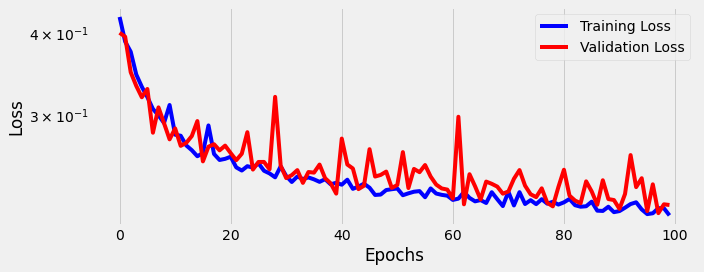

In [44]:
fig = FN_detector.plot_losses()

### Calculating the number of trainable parameters of the model

In [ ]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('pytorch_total_params: ', pytorch_total_params)
print('pytorch_total_trainable_params: ', pytorch_total_trainable_params)

In [ ]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)